## Redundancy Checker

### Chroma Creator

In [1]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key="pcsk_39X7W5_3wjJB2qbiri92uQNSN1K2ubxwTrPYTvZWqCGqmf66JCRuWY1iH4gayAGy3mzEos")

In [2]:
import chromadb
import numpy as np

# Initialize ChromaDB (Persistent storage)
chroma_client = chromadb.PersistentClient(path="./chroma_db")

# Create or get the collection
collection = chroma_client.get_or_create_collection(name="submissions_collection")

In [3]:
import pandas as pd

df = pd.read_csv('activity(1).csv')

# Convert column to list, ensuring all values are strings and handling NaNs
data_list = (
    df['activity'].astype(str) + " : " + df['description'].astype(str)
).tolist()

In [4]:
# # Process in batches of 96
# batch_size = 96

# for i in range(0, len(data_list), batch_size):
#     batch_data = data_list[i:i + batch_size]  # Get batch of 96 items
    
#     # Embed the batch
#     embeddings = pc.inference.embed(
#         model="llama-text-embed-v2",
#         inputs=batch_data,
#         parameters={"input_type": "passage"}
#     )

#     # Convert embeddings to numpy arrays
#     embeddings_np = [np.array(embedding["values"]).tolist() for embedding in embeddings]

#     # Generate unique IDs
#     ids = [str(idx) for idx in range(i, i + len(batch_data))]

#     # Add to ChromaDB
#     collection.add(
#         ids=ids,
#         embeddings=embeddings_np,
#         documents=batch_data,
#         metadatas=[{"text": text} for text in batch_data]
#     )

#     print(f"Inserted batch {i//batch_size + 1} into ChromaDB")

# print("All data successfully inserted into ChromaDB!")

In [5]:
query_text = "guide touristique"

# Embed the query
query_embedding = pc.inference.embed(
    model="llama-text-embed-v2",
    inputs=[query_text],
    parameters={"input_type": "passage"}
)[0]["values"]

# Search in ChromaDB
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=10  # Number of nearest neighbors
)

print(results)

{'ids': [['12', '177', '118', '469', '533', '310', '442', '575', '1108', '494']], 'embeddings': None, 'documents': [[None, None, None, None, None, None, None, None, None, None]], 'uris': None, 'data': None, 'metadatas': [[{'text': 'TOURISME : nan'}, {'text': 'Guide touristique : Guide touristique rondonee et bivouac'}, {'text': 'Guide touristique : Guide accompagnateur'}, {'text': 'Guide touristique : Guide touristique pour les voyages a la cartes des familles ou des associations'}, {'text': 'Publicité : Publicité'}, {'text': 'Restaurant : Restaurant'}, {'text': 'Guide touristique : Faire des sorties touristique autant que guide local'}, {'text': 'Service : commercial'}, {'text': 'Bijouterie : nan'}, {'text': 'Chauffeur : nan'}]], 'distances': [[0.28718239068984985, 0.3197137117385864, 0.3634410500526428, 0.3944925367832184, 0.41085168719291687, 0.4173186421394348, 0.42729124426841736, 0.4344240725040436, 0.4364321231842041, 0.4409964680671692]], 'included': [<IncludeEnum.distances: 'd

### Function Call for API

In [6]:
import numpy as np

embed_model = pc.inference

def check_and_insert_activity(activity_id, activity_title, activity_description, threshold=0.6):
    """
    Checks if an activity is redundant based on vector similarity and inserts it if not.
    
    Args:
        activity_title (str): Title of the activity.
        activity_description (str): Description of the activity.
        collection (ChromaDB Collection): The vector database collection.
        embed_model: The embedding model (e.g., Llama-text-embed-v2).
        threshold (float): Similarity threshold for redundancy check.
    
    Returns:
        dict: { "redundant": bool, "similar_activities": list of IDs }
    """
    # Combine title and description
    query_text = f"{activity_title} : {activity_description}"
    
    # Embed the query
    query_embedding = embed_model.embed(
        model="llama-text-embed-v2",
        inputs=[query_text],
        parameters={"input_type": "passage"}
    )[0]["values"]

    # Search in ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=10  # Get top 10 similar activities
    )

    # Extract results
    similarities = results["distances"][0]  # ChromaDB returns cosine distance
    activity_ids = results["ids"][0]  # Extract matching IDs

    # Convert cosine distance to similarity (cosine similarity = 1 - distance)
    similar_activity_ids = [
        activity_id for sim, activity_id in zip(similarities, activity_ids) if (1 - sim) > threshold
    ]

    # If redundancy is found, return the similar activity IDs
    if similar_activity_ids:
        return True, similar_activity_ids
    
    # Otherwise, insert the new activity into ChromaDB
    collection.add(
        embeddings=[query_embedding],
        metadatas=[{"text": query_text}],
        ids=[activity_id]
    )

    return False, []

### Check Redundancy

In [7]:
import pandas as pd

df = pd.read_csv('activity(1).csv')
df.index += 1

In [8]:
df_pc = pd.read_csv('progress_checkpoint.csv')
df_pc.index += 1
df_pc = df_pc[df_pc['redundant'].isin([True, False])]
df_pc['similar_activities'].fillna('', inplace=True)
df_pc

,code_pro,wilaya,field,activity,description,redundant,similar_activities
1,P6B3R8CC,Algiers,NaN,Technicien de Maintenance du matériel Prépress...,Le service Prépresse est équipé des machines C...,False,
2,LPC2SE3W,Algiers,Services à la personne,معالجة ملفات تأشيرة و خدمات الزبائن,معالجة ملفات تأشيرة وحجز مواعيد والتوجبه الزبا...,False,
3,DBX8Y5D7,Batna,"Conseil, Expertise et formation",مستشار مختص بتأشيرات السفر و برامج الهجرة,تقديم استشارات في مجال السفر و الهجرة من أجل م...,False,
4,PYC53DLT,Msila,Services à la personne,الرسم بالزيت والرمل,رسم أشخاص وطبيعة و مناظر صحراوية بالزيت والرمل,False,
5,TLLSNCC9,Algiers,Services à la personne,Dessinateur projeteur en travaux publics et su...,dessinateur projeteur en travaux publics (bâti...,False,
...,...,...,...,...,...,...,...
14896,T63Q764P,Touggourt,Services à la personne,الحلاقه والتجميل,تسريحات شعر ومكياج وتجميل البشرة,True,5825- 11037- 2424
14897,CYQM8LNH,Oran,Services aux entreprises,Chargé de logistique dans une entreprise de li...,Livraison de la marchandise (des colis de l’en...,False,
14898,7GZL3HTA,Oran,Services aux entreprises,Chargé de logistique dans une entreprise de li...,Livraison de la marchandise de l’entreprise de...,True,14897- 1438
14899,9YNSDXSC,Algiers,"Conseil, Expertise et formation",Consultant en management,Accompagnement des entreprises dans la gestion...,True,1841- 4072


In [9]:
selector = df.index.isin(df_pc.index.tolist())
df_done = df[selector]
df_todo = df[~selector]

redundant_list = df_pc['redundant'].tolist()
similar_activities_list = df_pc['similar_activities'].tolist()

df['redundant'] = None
df['similar_activities'] = ['' for x in range(len(df.index))]

In [10]:
df.loc[selector, 'redundant'] = redundant_list
df.loc[selector, 'similar_activities'] = similar_activities_list

df

/usr/lib/python3/dist-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/usr/lib/python3/dist-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,code_pro,wilaya,field,activity,description,redundant,similar_activities
1,P6B3R8CC,Algiers,NaN,Technicien de Maintenance du matériel Prépress...,Le service Prépresse est équipé des machines C...,False,
2,LPC2SE3W,Algiers,Services à la personne,معالجة ملفات تأشيرة و خدمات الزبائن,معالجة ملفات تأشيرة وحجز مواعيد والتوجبه الزبا...,False,
3,DBX8Y5D7,Batna,"Conseil, Expertise et formation",مستشار مختص بتأشيرات السفر و برامج الهجرة,تقديم استشارات في مجال السفر و الهجرة من أجل م...,False,
4,PYC53DLT,Msila,Services à la personne,الرسم بالزيت والرمل,رسم أشخاص وطبيعة و مناظر صحراوية بالزيت والرمل,False,
5,TLLSNCC9,Algiers,Services à la personne,Dessinateur projeteur en travaux publics et su...,dessinateur projeteur en travaux publics (bâti...,False,
...,...,...,...,...,...,...,...
14958,91BRUZKY,Constantine,Services à la personne,Distribution,Distribution de produits cosmétiques,None,
14959,LCKR2STV,Algiers,"Conseil, Expertise et formation",Conseil en Nutrition,Le conseil en nutrition vise à aider les indiv...,None,
14960,MBQNVBK2,Bouira,"Conseil, Expertise et formation","Expertise en Génie Civil, Ingénieur en Génie C...",NaN,None,
14961,BEB2S8T8,Bouira,Services aux entreprises,"Ingénieur en Génie Civil, Etude des structures...",NaN,None,


In [11]:
save_interval = 100

for index, row in df_todo.iterrows():
    redundant, similar_activities = check_and_insert_activity(str(row.name), row['activity'], row['description'])
    redundant_list.append(redundant)
    similar_activities_list.append("- ".join(similar_activities))  # Convert list to string
    
    if index % save_interval == 0:
        df.loc[:index, 'redundant'] = redundant_list
        df.loc[:index, 'similar_activities'] = similar_activities_list
        print(f'{index} - writing to csv...')
        df.to_csv("progress_checkpoint.csv", index=False)  # Change file name/path as needed

In [17]:
df['redundant'] = redundant_list
df['similar_activities'] = similar_activities_list

df['similar_activities'] = df['similar_activities'].str.split('- ').apply(lambda x: [int(i) for i in x if len(i) > 0])

df["similar_activities"] = df.apply(lambda row: [x for x in row["similar_activities"] if x != row.name], axis=1)
df["redundant"] = df["similar_activities"].apply(lambda x: False if len(x) == 0 else True)

df.to_csv("final_output.csv", index=False)

In [18]:
df[df['redundant'] == True]

,code_pro,wilaya,field,activity,description,redundant,similar_activities
31,QBV29664,Chlef,Prestations à domicile,بناء,بناء,True,[21]
44,135Y7C6M,Msila,Services aux entreprises,الأشغال الصغيرة للبناء والدهن,كل أعمال الجبس الفنية _x000D_\r\nحرفي جباس _x0...,True,[15]
47,4R5X9NP8,Bejaia,Services de loisirs et de récréation,Agence de voyage,NaN,True,[12]
53,8WGRQU9Z,Mostaganem,Services à la personne,حلويات,NaN,True,[21]
74,R3LEL5V2,Djelfa,"Conseil, Expertise et formation",Investissement,NaN,True,[12]
...,...,...,...,...,...,...,...
14954,SSFAZK3P,Sidi Bel Abbes,Services à la personne,صانع عصائر و مشروبات barman,صانع عصائر و مشروبات في المطاعم و المقاهي,True,[14083]
14956,WG8K44WD,Guelma,Services aux entreprises,مكتب دراسات تقنية هندسة مدنية,دراسات تقنية في مجال الهندسة المدينة_x000D_\r\...,True,[6342]
14957,C5KGKNRC,Tipaza,Services à la personne,Cuisine,NaN,True,"[2170, 561, 1129, 12]"
14958,91BRUZKY,Constantine,Services à la personne,Distribution,Distribution de produits cosmétiques,True,"[2941, 19, 10883, 4430, 846]"


In [35]:
df['cumulative_redundant'] = df['redundant'].cumsum()
df.head()

,code_pro,wilaya,field,activity,description,redundant,similar_activities,cumulative_redundant
1,P6B3R8CC,Algiers,NaN,Technicien de Maintenance du matériel Prépress...,Le service Prépresse est équipé des machines C...,False,[],0
2,LPC2SE3W,Algiers,Services à la personne,معالجة ملفات تأشيرة و خدمات الزبائن,معالجة ملفات تأشيرة وحجز مواعيد والتوجبه الزبا...,False,[],0
3,DBX8Y5D7,Batna,"Conseil, Expertise et formation",مستشار مختص بتأشيرات السفر و برامج الهجرة,تقديم استشارات في مجال السفر و الهجرة من أجل م...,False,[],0
4,PYC53DLT,Msila,Services à la personne,الرسم بالزيت والرمل,رسم أشخاص وطبيعة و مناظر صحراوية بالزيت والرمل,False,[],0
5,TLLSNCC9,Algiers,Services à la personne,Dessinateur projeteur en travaux publics et su...,dessinateur projeteur en travaux publics (bâti...,False,[],0


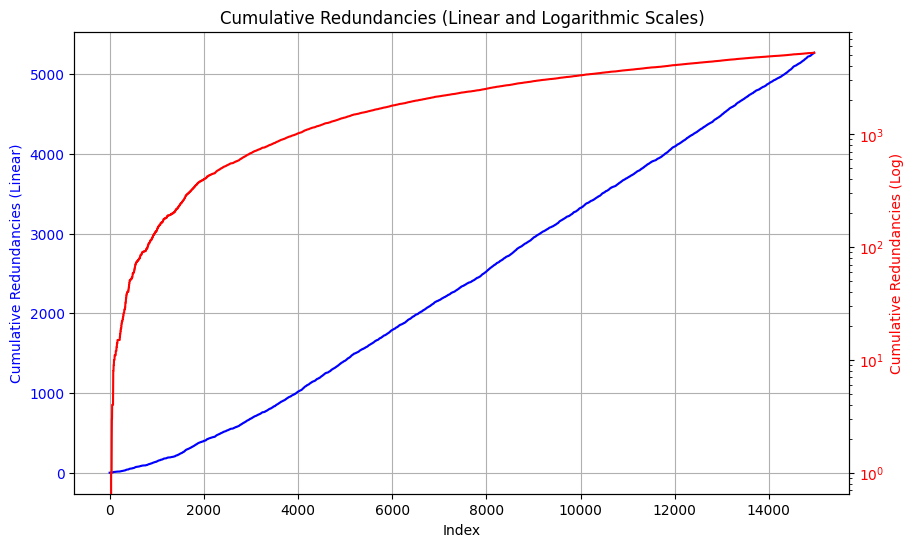

In [38]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the cumulative sum on the left axis (linear scale)
ax1.plot(df['cumulative_redundant'], label='Cumulative Redundancies (Linear)', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Cumulative Redundancies (Linear)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for the logarithmic scale
ax2 = ax1.twinx()
ax2.plot(df['cumulative_redundant'], label='Cumulative Redundancies (Logarithmic)', color='red')
ax2.set_ylabel('Cumulative Redundancies (Log)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_yscale('log')

# Set the title
plt.title('Cumulative Redundancies (Linear and Logarithmic Scales)')
plt.savefig('redundancy_growth.png')
plt.show()

In [19]:
100 * len(df[df['redundant'] == True]) / len(df)

35.21588022991579

#### Woow! 35.22% reduction of submission to be processed!